## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb 

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice. 
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

In [1]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 27

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 

In [3]:
from sklearn.datasets import fetch_20newsgroups

# load only a sub-selection of the categories (4 in our case)
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space'] 

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [4]:
from collections import Counter
Counter(newsgroups_train.target)

Counter({3: 593, 1: 584, 2: 594, 0: 480})

In [5]:
Counter(newsgroups_test.target)

Counter({1: 389, 2: 396, 0: 319, 3: 394})

In [6]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})

In [7]:
print(len(train))
train.head(5)

2251


,text,labels
0,WHile we are on the subject of the shuttle sof...,3
1,There is a program called Graphic Workshop you...,1
2,,2
3,My girlfriend is in pain from kidney stones. S...,2
4,I think that's the correct spelling..\n\tI am ...,2


In [8]:
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

In [9]:
print(len(test))
test.head(5)

1498


,text,labels
0,\nAnd guess who's here in your place.\n\nPleas...,1
1,Does anyone know if any of Currier and Ives et...,1
2,=FLAME ON\n=\n=Reading through the posts about...,2
3,\nBut in this case I said I hoped that BCCI wa...,0
4,\nIn the kind I have made I used a Lite sour c...,2


In [10]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

In [11]:
print(len(train))
print("train:", train[['labels']].value_counts(sort=False))
train.head(3)

2025
train: labels
0         432
1         525
2         534
3         534
dtype: int64


,text,labels
559,I wonder how many atheists out there care to s...,0
2060,We are interested in purchasing a grayscale pr...,1
1206,"Dear Binary Newsers,\n\nI am looking for Quick...",1


In [12]:
print(len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))
dev.head(3)

226
dev: labels
0         48
1         59
2         60
3         59
dtype: int64


,text,labels
1570,I'd dump him. Rude is rude and it seems he en...,2
1761,Hi Everyone ::\n\nI am looking for some soft...,1
455,A friend of mine has been diagnosed with Psori...,2


## RoBERTa model

In [40]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how

In [41]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 64 steps.


In [42]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loadi

In [43]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=8
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_seed=

In [44]:
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/2025 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-32/config.json
Model weights saved in outputs/checkpoint-32/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-32/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-32/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-64/config.json
Model weights saved in outputs/checkpoint-64/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-64/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-64/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json
Configuration saved in outputs/checkpoint-64-epoch-1/config.json
Model weights saved in outputs/checkpoint-64-epoch-1/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-64-epoch-1/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-64-epoch-1/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-96/config.json
Model weights saved in outputs/checkpoint-96/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-96/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-96/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-128/config.json
Model weights saved in outputs/checkpoint-128/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-128/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-128/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json
Configuration saved in outputs/checkpoint-128-epoch-2/config.json
Model weights saved in outputs/checkpoint-128-epoch-2/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-128-epoch-2/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-128-epoch-2/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-160/config.json
Model weights saved in outputs/checkpoint-160/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-160/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-160/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-192/config.json
Model weights saved in outputs/checkpoint-192/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-192/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-192/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json
Configuration saved in outputs/checkpoint-192-epoch-3/config.json
Model weights saved in outputs/checkpoint-192-epoch-3/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-192-epoch-3/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-192-epoch-3/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-224/config.json
Model weights saved in outputs/checkpoint-224/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-224/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-224/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-256/config.json
Model weights saved in outputs/checkpoint-256/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-256/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-256/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json
Configuration saved in outputs/checkpoint-256-epoch-4/config.json
Model weights saved in outputs/checkpoint-256-epoch-4/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-256-epoch-4/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-256-epoch-4/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-288/config.json
Model weights saved in outputs/checkpoint-288/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-288/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-288/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-320/config.json
Model weights saved in outputs/checkpoint-320/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-320/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-320/special_tokens_map.json
Configuration saved in outputs/checkpoint-320-epoch-5/config.json
Model weights saved in outputs/checkpoint-320-epoch-5/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-320-epoch-5/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-320-epoch-5/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-352/config.json
Model weights saved in outputs/checkpoint-352/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-352/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-352/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-384/config.json
Model weights saved in outputs/checkpoint-384/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-384/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-384/special_tokens_map.json
Configuration saved in outputs/best_model/config.json
Model weights saved in outputs/best_model/pytorch_model.bin
tokenizer config file saved in outputs/best_model/tokenizer_config.json
Special tokens file saved in outputs/best_model/special_tokens_map.json
Configuration saved in outputs/checkpoint-384-epoch-6/config.json
Model weights saved in outputs/checkpoint-384-epoch-6/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-384-epoch-6/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-384-epoch-6/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-416/config.json
Model weights saved in outputs/checkpoint-416/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-416/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-416/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-448/config.json
Model weights saved in outputs/checkpoint-448/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-448/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-448/special_tokens_map.json
Configuration saved in outputs/checkpoint-448-epoch-7/config.json
Model weights saved in outputs/checkpoint-448-epoch-7/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-448-epoch-7/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-448-epoch-7/special_tokens_map.json


  0%|          | 0/226 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

Configuration saved in outputs/checkpoint-480/config.json
Model weights saved in outputs/checkpoint-480/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-480/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-480/special_tokens_map.json
Configuration saved in outputs/config.json
Model weights saved in outputs/pytorch_model.bin
tokenizer config file saved in outputs/tokenizer_config.json
Special tokens file saved in outputs/special_tokens_map.json


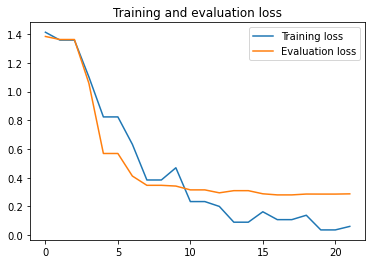

In [45]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [46]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/226 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/29 [00:00<?, ?it/s]

{'mcc': 0.8407842504687129, 'eval_loss': 0.2880030007197939}

In [47]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/1498 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

In [48]:
test.head(5)

,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,1
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,0
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2


In [49]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       319
           1       0.90      0.91      0.90       389
           2       0.89      0.88      0.89       396
           3       0.82      0.83      0.82       394

    accuracy                           0.86      1498
   macro avg       0.86      0.86      0.86      1498
weighted avg       0.86      0.86      0.86      1498



Both models seem to perform well in terms of accuracy, with an accuracy score of 0.86 and 0.87 respectively. However, when comparing the results of the two models, it seems that the second model performs slightly better than the first one.

This is mainly due to the fact that the second model has slightly higher precision and recall scores across all classes, as well as a higher F1-score. In particular, the second model has higher precision scores for classes 0 and 2, higher recall scores for classes 1 and 3, and higher F1-scores for classes 1 and 2.

Therefore, if we consider precision and recall as important metrics, we would conclude that the second model performs slightly better than the first one. 

When we compare roBERTa model and SVM using bag-of-words model regarding their performance using precision, recall metrics, roBERTa tends to have higher precision score than SVM using bag-of-words thanks to its ability to learn more complex links between words and their contexts. 
Whereas SVM using bag-of-words may have higher recall score than the other model because it is more focused on individual words and their frequency in the text considering recall score shows the percentage of examples that are successfully categorized out of all the instances that fall under a given class. 
